In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

# Load the dataset (assuming it's already loaded as a DataFrame named `data`)
data = pd.read_csv(os.path.join(os.getcwd(), "../../data/for_lstm1.csv"), index_col=0)


Epoch [10/200], Loss: 1.0598
Epoch [20/200], Loss: 1.0525
Epoch [30/200], Loss: 1.0499
Epoch [40/200], Loss: 1.0395
Epoch [50/200], Loss: 1.0338
Epoch [60/200], Loss: 1.0305
Epoch [70/200], Loss: 1.0229
Epoch [80/200], Loss: 1.0172
Epoch [90/200], Loss: 1.0131
Epoch [100/200], Loss: 1.0105
Epoch [110/200], Loss: 1.0058
Epoch [120/200], Loss: 1.0029
Epoch [130/200], Loss: 0.9975
Epoch [140/200], Loss: 0.9952
Epoch [150/200], Loss: 0.9885
Epoch [160/200], Loss: 0.9843
Epoch [170/200], Loss: 0.9821
Epoch [180/200], Loss: 0.9976
Epoch [190/200], Loss: 0.9894
Epoch [200/200], Loss: 1.0143
Accuracy: 0.4414


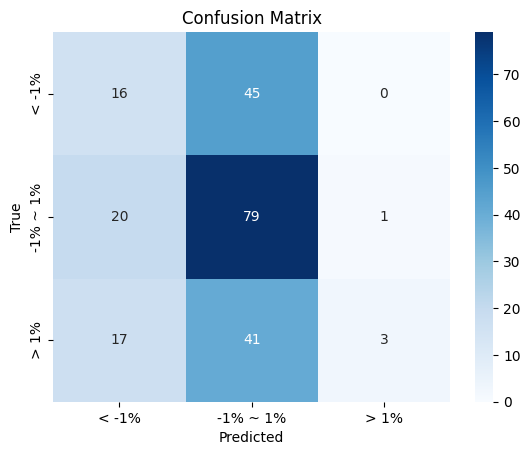

In [16]:

# Calculate the percentage change in close price for the next day
data['price_pct_change_next'] = data['close'].pct_change().shift(-1) * 100

# Drop the last row since it won't have a next day's percentage change
data.dropna(inplace=True)

# Select the features you want to use
features = ['open', 'high', 'low', 'close', 'volume_krw', 'price_pct_change', 
            'volume__pct_change', 'ma_5', 'ma_50', 'mmt_120_score', 'rsi']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Function to create sequences of data for LSTM, now with classification labels
def create_sequences(data, pct_change, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        if pct_change[i+seq_length] > 1:
            y.append(2)  # Class 2: More than 1%
        elif pct_change[i+seq_length] < -1:
            y.append(0)  # Class 0: Less than -1%
        else:
            y.append(1)  # Class 1: Between -1% and 1%
    return np.array(x), np.array(y)

seq_length = 7  # Number of previous days to consider for predicting the next day
x, y = create_sequences(scaled_data, data['price_pct_change_next'].values, seq_length)

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # Note: Use long for classification labels
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)  # Note: Use long for classification labels

# Define the LSTM model for classification
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer to output the class probabilities
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Model parameters
input_size = len(features)  # Number of features
hidden_size = 64  # Number of LSTM units
num_layers = 4  # Number of LSTM layers
output_size = 3  # We have three classes (less than -1%, between -1% and 1%, more than 1%)

model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop with gradient clipping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(x_train)
    optimizer.zero_grad()
    
    # Calculate the loss
    loss = criterion(outputs, y_train)
    
    # Backpropagation and optimization
    loss.backward()
    
    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(x_test)
    _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
    correct = (predicted == y_test).sum().item()
    accuracy = correct / y_test.size(0)
    print(f'Accuracy: {accuracy:.4f}')

# Confusion matrix to see the classification performance
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.numpy(), predicted.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['< -1%', '-1% ~ 1%', '> 1%'], yticklabels=['< -1%', '-1% ~ 1%', '> 1%'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()